# Wannier equation and BSE unification

## Import statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.linalg as LA
import itertools as it
import pandas as pd

In [2]:
## Turn the parent directory visible for importing
import sys
sys.path.insert(1,'../')

In [3]:
import hamiltonians as ham
import bse_solver as bse_solver
import bethe_salpeter_equation as bse_builder
import physical_constants as const

In [4]:
#  Font definitions for the plots
FONT_LABELS = 20
FONT_TITLES = 22
# font = {'family' : 'serif', 'weight' : 'bold', 'size': FONT_LABELS}
# mpl.rc('font', **font)
# plt.rc('text', usetex=True)

# Binding energy calculation

## `k-space` definition 

In [5]:
Lk = 5
n_sites = 11

Kx, Ky, dk2 = bse_builder.define_grid_k(Lk, n_sites) # nm^-1

## Electron-Hole interaction

In [6]:
r_0 = 4.5 # nm
epsilon = 1
potential = ham.Rytova_Keldysh(dk2=dk2, r_0=r_0, epsilon=epsilon)

## Wannier equation solution

### Hamiltonian

In [7]:
m_1 = 0.25 # electron effective mass 1
m_2 = 0.15 # electron effective mass 2
m_3 = 0.40 # hole effective mass

E_2 = 2.40e3 # meV
E_1 = 2.45e3 # meV

H_Wannier_1 = ham.H_Wannier(m_1, m_3, Egap=E_1)
H_Wannier_2 = ham.H_Wannier(m_2, m_3, Egap=E_2)

In [8]:
print("Wannier 1:")
print("m_e \t= {0:.2} \nm_h \t= {1:.2} \nmu \t= {2:.2}".format(m_1, m_3, H_Wannier_1.m_eff))

Wannier 1:
m_e 	= 0.25 
m_h 	= 0.4 
mu 	= 0.15


In [9]:
print("Wannier 2:")
print("m_e \t= {0:.2} \nm_h \t= {1:.2} \nmu \t= {2:.2}".format(m_2, m_3, H_Wannier_2.m_eff))

Wannier 2:
m_e 	= 0.15 
m_h 	= 0.4 
mu 	= 0.11


### Building the Wannier equation matrix

In [10]:
## KINETIC CONTRIBUTION
wannier_kinetic_1 = ham.kinetic_wannier(H_Wannier_1, Kx, Ky)
wannier_kinetic_2 = ham.kinetic_wannier(H_Wannier_2, Kx, Ky)

## POTENTIAL CONTRIBUTION'
N_submesh = 11
submesh_radius = 1
wannier_potential = bse_builder.potential_matrix(potential, Kx, Ky, N_submesh, submesh_radius=submesh_radius)

In [11]:
# plt.imshow(wannier_kinetic_1, cmap='inferno')

In [12]:
# plt.imshow(wannier_potential_1, cmap='inferno')

In [13]:
wannier_matrix_total_1 = wannier_kinetic_1 + wannier_potential
wannier_matrix_total_2 = wannier_kinetic_2 + wannier_potential

In [14]:
# plt.imshow(wannier_matrix_total_1,cmap='inferno')

### Solve for the eigenvalues and eigenvectors

In [15]:
n_rec_states = 11**2
values_Wannier_1, vectors_Wannier_1 = bse_solver.diagonalize_bse(wannier_matrix_total_1, 
                                                                 n_rec_states, arpack=False)

values_Wannier_2, vectors_Wannier_2 = bse_solver.diagonalize_bse(wannier_matrix_total_2, 
                                                                 n_rec_states, arpack=False)

In [16]:
print(values_Wannier_1[0:7].round(4))
print(values_Wannier_2[0:7].round(4))

[-339.4469  -98.4229  -40.5658  -40.5658   -8.4528  203.7828  217.5243]
[-320.3818   -0.7204   64.9041   64.9041   93.5776  400.9288  419.5639]


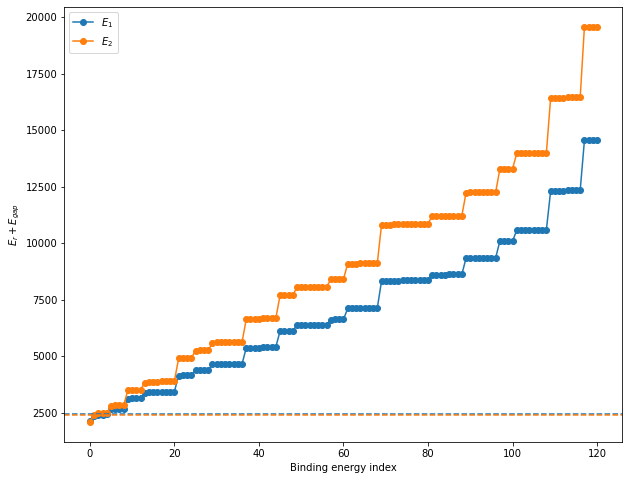

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(values_Wannier_1 + H_Wannier_1.Egap, '-o', c='C0', label='$E_1$')
ax.plot(values_Wannier_2 + H_Wannier_2.Egap, '-o', c='C1',label='$E_2$')
ax.axhline(y=H_Wannier_1.Egap,ls='--',c='C0')
ax.axhline(y=H_Wannier_2.Egap,ls='--',c='C1')
ax.set_xlabel('Binding energy index')
ax.set_ylabel(r'$E_r + E_{gap}$')
ax.legend()
# ax.set_ylim([1900, 5000])
# ax.set_xlim([-2,40])

## BSE solution 2x2

### 2x2 diagonal Hamiltonian: BSE decoupled

In [18]:
alpha_c1 =  1/m_1  # m1 == 0.25
alpha_c2 =  1/m_2  # m2 == 0.15
alpha_v  = -1/m_3  # m3 == 0.40
E_1      = 2.45e3  # meV
E_2      = 2.40e3  # meV
gamma    = 0

H_2x2_1 = ham.H2x2(alpha_c1, alpha_v, E_1, gamma)
H_2x2_2 = ham.H2x2(alpha_c2, alpha_v, E_2, gamma)

In [19]:
kx_array = np.linspace(-5,5,201)  # nm^-1
bands_1 = [LA.eigh(H_2x2_1.call(kx,0))[0] for kx in kx_array]
bands_2 = [LA.eigh(H_2x2_2.call(kx,0))[0] for kx in kx_array]

In [201]:
print(bands_1[0])
bands_1_array = np.array(bands_1)
# print(bands_1_array[:,0])

[-2381.23861388  6259.98178221]


m_e = 0.25, E_g= 2.45 eV
m_e = 0.15, E_g= 2.4 eV


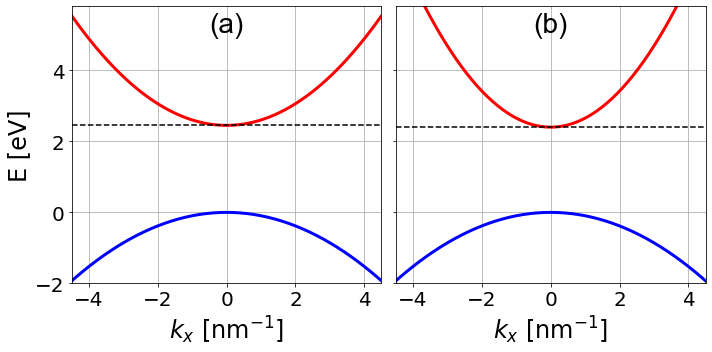

In [210]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].plot(kx_array, np.array(bands_1)[:,0]/1000, c='b', lw=3)
ax[0].plot(kx_array, np.array(bands_1)[:,1]/1000, c='r', lw=3)

ax[1].plot(kx_array, np.array(bands_2)[:,0]/1000, c='b', lw=3)
ax[1].plot(kx_array, np.array(bands_2)[:,1]/1000, c='r', lw=3)

Hlist = [H_2x2_1, H_2x2_2]
for i in [0,1]:
    print('m_e = {:.2f}, E_g= {:.3} eV'.format(1/Hlist[i].alphac, 1e-3*Hlist[i].Egap))
    ax[i].tick_params(labelsize=20)
#     ax[i].set_title('$m_e =$ {:.2f}, $E_g=$ {:.3} eV'.format(1/Hlist[i].alphac, 1e-3*Hlist[i].Egap))
    ax[i].axhline(y = 1e-3*Hlist[i].Egap, ls='--', c='k')
    ax[i].set_xlabel('$k_x$ [nm$^{-1}$]', fontsize=24)
    ax[i].set_xlim((-4.5,4.5))
    ax[i].set_ylim(-2,5.8)
    ax[i].grid()
    
ax[0].set_ylabel('E [eV]', fontsize=24)
ax[1].get_yaxis().set_ticklabels([])

ax[0].text(0.5, 0.98,'(a)',
           fontsize=28,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = ax[0].transAxes)
ax[1].text(0.5, 0.98,'(b)',
           fontsize=28,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = ax[1].transAxes)

plt.tight_layout()
plt.savefig('bands_BSE_H2x2.png', dpi=300)
plt.show()

In [21]:
states_1 = [LA.eigh(H_2x2_1.call(kx,0))[1] for kx in kx_array]

In [22]:
print(states_1[0].shape)
print(states_1[0])
states_composition = [np.real(matrix_states @ np.array([1,-1])) for matrix_states in states_1]

(2, 2)
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]


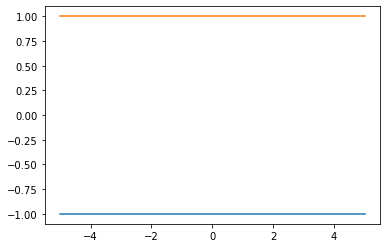

In [23]:
plt.plot(kx_array, states_composition)

### Building the BSE matrix

In [24]:
# EIGENVALUES AND EIGENVECTORS OF AOR MODEL FOR EACH OF THE K-POINTS
Values2x2_1, Vectors2x2_1 = ham.values_and_vectors(H_2x2_1, Kx, Ky)
Values2x2_2, Vectors2x2_2 = ham.values_and_vectors(H_2x2_2, Kx, Ky)

### THE BETHE-SALPETER MATRIX CONSTRUCTION:
Nk = Kx.shape[0]
print("Building Potential matrix ({} x {})... ".format(Nk,Nk))
V_kk = wannier_potential

print("Including 'mixing' terms (Deltas)... ")
BSE_potential_1 = bse_builder.include_deltas(V_kk, Values2x2_1, Vectors2x2_1, N_submesh, H_2x2_1)
BSE_potential_2 = bse_builder.include_deltas(V_kk, Values2x2_2, Vectors2x2_2, N_submesh, H_2x2_2)

print("Including 'pure' diagonal elements..")
BSE_kinetic_1 = bse_builder.diagonal_elements(Values2x2_1, H_2x2_1)
BSE_kinetic_2 = bse_builder.diagonal_elements(Values2x2_2, H_2x2_2)

Building Potential matrix (11 x 11)... 
Including 'mixing' terms (Deltas)... 
Including 'pure' diagonal elements..


In [25]:
# plt.imshow(BSE_kinetic_1)

In [26]:
# [BSE_kinetic_1[i,i] for i in range(4)]

In [27]:
# plt.imshow(np.real(BSE_potential_1))

In [28]:
BSE_potential_1[0,0]

(-287.257230407915+0j)

In [29]:
BSE_potential_2[0,0]

(-287.257230407915+0j)

In [30]:
wannier_potential[0,0]

-287.257230407915

In [31]:
BSE_matrix_total_1 = BSE_kinetic_1 + BSE_potential_1
BSE_matrix_total_2 = BSE_kinetic_2 + BSE_potential_2

### Solve for the eigenvalues and eigenvectors

In [32]:
n_rec_states = 11**2
values_2x2_1, vectors_2x2_1 = bse_solver.diagonalize_bse(BSE_matrix_total_1, n_rec_states, arpack=False)
values_2x2_2, vectors_2x2_2 = bse_solver.diagonalize_bse(BSE_matrix_total_2, n_rec_states, arpack=False)

In [33]:
print("BSE 2x2 1")
print("E_gap = %.2e" % H_2x2_1.Egap)
print("m_c = %.2f" % (1/H_2x2_1.alphac))
print("m_v = %.2f" % (1/H_2x2_1.alphav))

BSE 2x2 1
E_gap = 2.45e+03
m_c = 0.25
m_v = -0.40


In [34]:
print("BSE 2x2 2")
print("E_gap = %.2e" % H_2x2_2.Egap)
print("m_c = %.2f" % (1/H_2x2_2.alphac))
print("m_v = %.2f" % (1/H_2x2_2.alphav))

BSE 2x2 2
E_gap = 2.40e+03
m_c = 0.15
m_v = -0.40


In [35]:
values_2x2_1[:5].round(4) - H_2x2_1.Egap

array([-339.4469,  -98.4229,  -40.5658,  -40.5658,   -8.4528])

In [36]:
values_Wannier_1[:5].round(4)

array([-339.4469,  -98.4229,  -40.5658,  -40.5658,   -8.4528])

In [37]:
values_2x2_2[:5].round(4) - H_2x2_2.Egap

array([-320.3818,   -0.7204,   64.9041,   64.9041,   93.5776])

In [38]:
values_Wannier_2[:5].round(4)

array([-320.3818,   -0.7204,   64.9041,   64.9041,   93.5776])

In [39]:
H_2x2_1.alphac

4.0

In [40]:
H_2x2_2.alphac

6.666666507720947

In [41]:
H_2x2_2.Egap

2400.0

## BSE solution 3x3

### 3x3 diagonal Hamiltonian: BSE decoupled

In [42]:
E_3 = 0.
E_2 = 2.40e3
E_1 = 2.45e3
m_3 = -0.4
m_2 = 0.15
m_1 = 0.25
P_10 = 0
P_20 = 0
P_21 = 0
P_sign = +1

H_3x3 = ham.H3x3(E_3, E_2, E_1, m_3, m_2, m_1, P_10, P_20, P_21, P_sign, P_sign)

In [43]:
H_3x3.call(0,0)

array([[2450.+0.j,    0.+0.j,    0.+0.j],
       [   0.+0.j, 2400.+0.j,    0.+0.j],
       [   0.+0.j,    0.+0.j,    0.+0.j]])

In [44]:
bands3x3 = [LA.eigh(H_3x3.call(kx,0))[0] for kx in kx_array]
bands3x3array = np.array(bands3x3)
bands3x3array.shape

(201, 3)

In [45]:
vectors3x3 = np.array([LA.eigh(H_3x3.call(kx,0))[1] for kx in kx_array])

In [46]:
len(vectors3x3)

201

In [47]:
vectors3x3.shape

(201, 3, 3)

In [48]:
for i in range(10):
    print(vectors3x3[i,:,1] @ np.array([1,-1,0]) > 0)

True
True
True
True
True
True
True
True
True
True


In [49]:
def order_bands(bands_array, vectors):
    vect_test = np.array([1,-1,0])
    n_values = len(bands_array)
    bands_new = np.empty_like(bands_array)
    for i in range(n_values):
        if vectors[i,:,1] @ vect_test > 0:
            bands_new[i,:] = bands_array[i,0], bands_array[i,2], bands_array[i,1]
        else:
            bands_new[i,:] = bands_array[i,:]
    return bands_new

In [50]:
bands3x3_organized = order_bands(np.array(bands3x3), vectors3x3)

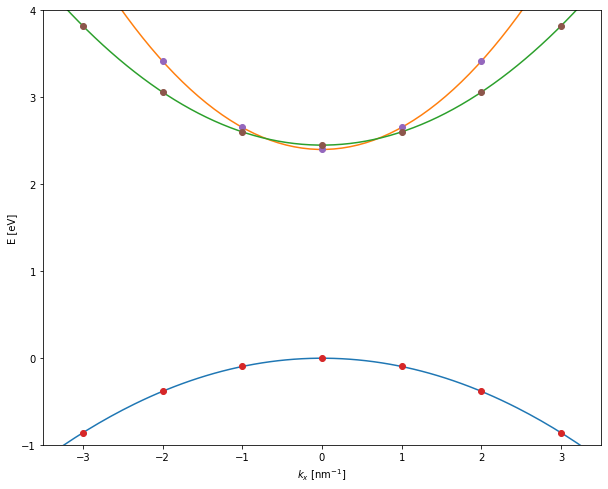

In [51]:
fig, ax = plt.subplots(figsize=(10,8))
# ax.plot(kx_array, np.array(bands3x3)/1000)
# ax.plot(kx_array, np.array(bands3x3)/1000, 'o', markevery=20)

ax.plot(kx_array, np.array(bands3x3_organized)/1000)
ax.plot(kx_array, np.array(bands3x3_organized)/1000, 'o', markevery=20)

ax.set_ylim((-1,4))
ax.set_xlim((-3.5,3.5))
ax.set_xlabel('$k_x$ [nm$^{-1}$]')
ax.set_ylabel('E [eV]')
plt.show()

In [52]:
states3x3 = [LA.eigh(H_3x3.call(kx,0))[1] for kx in kx_array]
states_composition_3x3 = [np.real(matrix_states @ np.array([-1,1,2])) for matrix_states in states3x3]

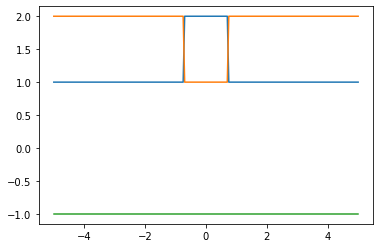

In [53]:
plt.plot(kx_array, states_composition_3x3)
plt.show()

In [54]:
np.abs(states3x3[0])

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [55]:
states_composition_3x3[0]

array([ 1.,  2., -1.])

In [56]:
bands3x3[0]

array([-2381.2385784 ,  6259.98178221,  8749.96938469])

In [57]:
H_3x3.call(-5,0)

array([[ 6259.98178221+0.j,     0.        +0.j,     0.        +0.j],
       [    0.        +0.j,  8749.96938469+0.j,     0.        +0.j],
       [    0.        +0.j,     0.        +0.j, -2381.2385784 +0.j]])

### Building the BSE matrix

In [58]:
# EIGENVALUES AND EIGENVECTORS OF AOR MODEL FOR EACH OF THE K-POINTS
Values3D_3x3, Vectors4D_3x3 = ham.values_and_vectors(H_3x3, Kx, Ky)

### THE BETHE-SALPETER MATRIX CONSTRUCTION:
Nk = Kx.shape[0]
print("\tBuilding Potential matrix ({} x {})... ".format(Nk,Nk))
V_kk = wannier_potential

print("\tIncluding 'mixing' terms (Deltas)... ")
BSE_potential_3x3 = bse_builder.include_deltas(V_kk, Values3D_3x3, Vectors4D_3x3, N_submesh, H_3x3)

print("\tIncluding 'pure' diagonal elements..")
BSE_kinetic_3x3 = bse_builder.diagonal_elements(Values3D_3x3, H_3x3)

	Building Potential matrix (11 x 11)... 
	Including 'mixing' terms (Deltas)... 
	Including 'pure' diagonal elements..


In [59]:
BSE_kinetic_3x3.shape

(242, 242)

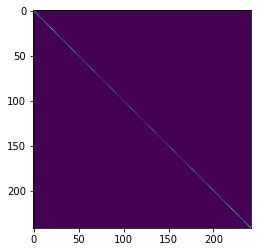

In [60]:
plt.imshow(BSE_kinetic_3x3)

In [61]:
BSE_kinetic_3x3[:3,:3]

array([[19862.41592616,     0.        ,     0.        ],
       [    0.        , 14832.4407212 ,     0.        ],
       [    0.        ,     0.        , 16719.18105945]])

In [62]:
[BSE_kinetic_3x3[i,i] for i in range(4)]

[19862.41592616251, 14832.440721204246, 16719.181059453254, 12603.601391387481]

In [63]:
[BSE_kinetic_1[i,i] for i in range(4)]

[14832.440792170686, 12603.60144957996, 10870.059738676067, 9631.815659458998]

In [64]:
[BSE_kinetic_2[i,i] for i in range(4)]

[19862.416198989027, 16719.181283171, 14274.443015312538, 12528.201395413635]

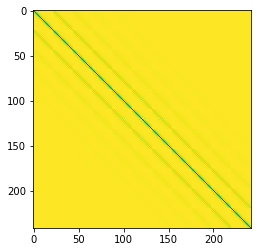

In [65]:
plt.imshow(np.real(BSE_potential_3x3))

In [66]:
BSE_matrix_total_3x3 = BSE_kinetic_3x3 + BSE_potential_3x3 

In [67]:
np.abs(BSE_matrix_total_3x3[:4,:4])

array([[19575.15869575,     0.        ,    41.66863158,     0.        ],
       [    0.        , 14545.1834908 ,     0.        ,    41.66863158],
       [   41.66863158,     0.        , 16431.92382905,     0.        ],
       [    0.        ,    41.66863158,     0.        , 12316.34416098]])

In [68]:
np.abs(BSE_matrix_total_2[:2,:2])

array([[19575.15896858,    41.66863158],
       [   41.66863158, 16431.92405276]])

In [69]:
np.abs(BSE_matrix_total_1[:2,:2])

array([[14545.18356176,    41.66863158],
       [   41.66863158, 12316.34421917]])

### Solving for the eigenvalues and eigenvectors

In [70]:
n_rec_states = 242
values_3x3, vectors_3x3 = bse_solver.diagonalize_bse(BSE_matrix_total_3x3, n_rec_states, arpack=False)

In [71]:
values_3x3[:10].round(1)

array([2079.6, 2110.6, 2351.6, 2399.3, 2409.4, 2409.4, 2441.5, 2464.9,
       2464.9, 2493.6])

In [72]:
values_3x3[:10:2].round(1)

array([2079.6, 2351.6, 2409.4, 2441.5, 2464.9])

In [73]:
values_2x2_2[:5].round(1)

array([2079.6, 2399.3, 2464.9, 2464.9, 2493.6])

In [74]:
values_3x3[1:10:2].round(1)

array([2110.6, 2399.3, 2409.4, 2464.9, 2493.6])

In [75]:
values_2x2_1[:5].round(1)

array([2110.6, 2351.6, 2409.4, 2409.4, 2441.5])

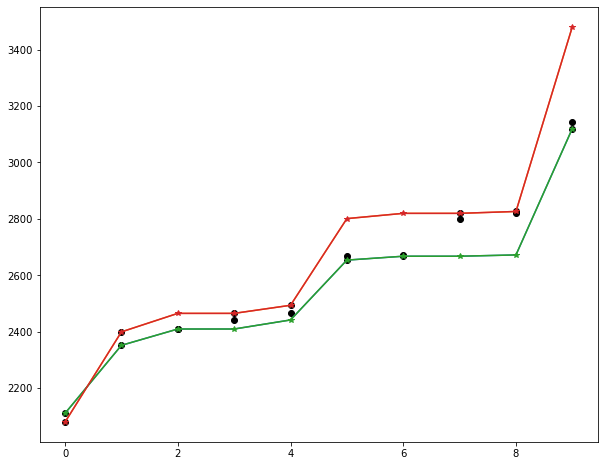

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(values_3x3[:20:2], 'o', c='k')
ax.plot(values_3x3[1:20:2], 'o', c='k')
ax.plot(values_2x2_1[:10])
ax.plot(values_2x2_2[:10])
ax.plot(values_Wannier_1[:10]+H_Wannier_1.Egap,'-*')
ax.plot(values_Wannier_2[:10]+H_Wannier_2.Egap,'-*')

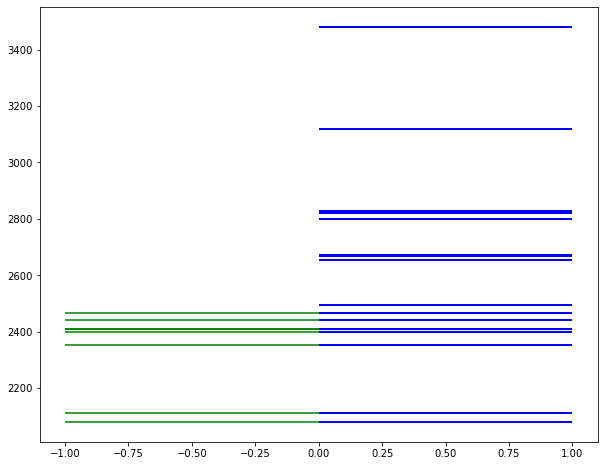

In [77]:
NWannier = 10
NBSE = 8
fig, ax = plt.subplots(figsize=(10,8))
ax.hlines(y=values_Wannier_1[:NWannier]+H_Wannier_1.Egap, xmin=0, xmax=1, ls='-',colors='b', lw=2)
ax.hlines(y=values_Wannier_2[:NWannier]+H_Wannier_2.Egap, xmin=0, xmax=1, ls='-',colors='b', lw=2)
ax.hlines(y=values_3x3[:NBSE], xmin=-1,xmax=0, ls='-', colors='g')
plt.show()

In [78]:

def count_states(values):
    dots = [1]
    values_unique = [values[0]]
    for i in range(len(values)-1):
        if (values[i+1] - values[i]) < 1e-5:
            dots[-1] += 1
        else:
            dots.append(1)
            values_unique.append(values[i+1])
    return values_unique, dots

In [79]:
unique_Wannier_1, multiplicity_Wannier_1 = count_states(values_Wannier_1) 

In [80]:
unique_Wannier_1[0]

-339.446914136142

(-450.0, 2000.0)

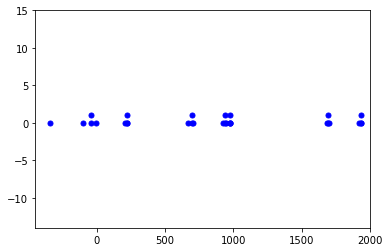

In [81]:
for i in range(len(unique_Wannier_1)):
    plt.plot(multiplicity_Wannier_1[i]*[unique_Wannier_1[i]], list(range(multiplicity_Wannier_1[i])),
             'bo', markersize=5)
plt.ylim([-14,15])
plt.xlim((-450,2000))

<ipython-input-222-39da7b43c685>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.get_yaxis().set_ticklabels(['',r'Wannier 1',r'BSE-$3\times3$',r'Wannier 2',r''])


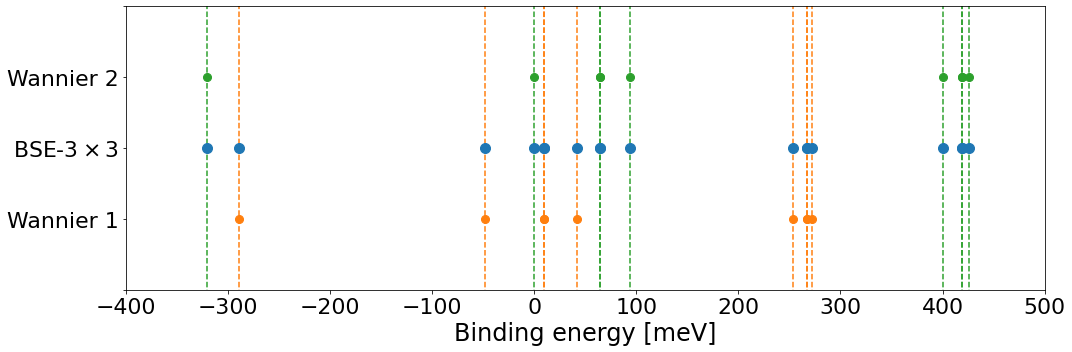

In [222]:
Ndata = 121

delta_Egap = H_Wannier_1.Egap - H_Wannier_2.Egap

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(values_3x3[:Ndata] - H_Wannier_2.Egap, np.zeros(Ndata), 'o', ms=10, label=r'BSE-$3\times3$')

ax.plot(values_Wannier_1[:Ndata//2] + delta_Egap, np.zeros(Ndata//2)-1, 'o', ms=8, label='Wannier 1')
ax.plot(values_Wannier_2[:Ndata//2], np.zeros(Ndata//2)+1, 'o', ms=8, label='Wannier 2')

ax.vlines(x=[values_Wannier_2], ymin=-5, ymax=5, ls='--', colors='C2')
ax.vlines(x=[values_Wannier_1 + delta_Egap], ymin=-5, ymax=5, ls='--', colors='C1')

ax.set_ylim([-2,2])
ax.set_xlim([-400,500])
ax.set_xlabel('Binding energy [meV]', fontsize=24)
ax.tick_params(labelsize=22)
ax.get_yaxis().set_ticklabels(['',r'Wannier 1',r'BSE-$3\times3$',r'Wannier 2',r''])
# ax.legend(fontsize=24, loc=[0.15,0.5])
plt.tight_layout()
plt.savefig('comparando_bse3x3_wannier_energies.png', dpi=200)
plt.show()


In [83]:
print(values_3x3[0] - H_Wannier_2.Egap)
print(values_Wannier_1[0] + abs(H_Wannier_2.Egap-H_Wannier_1.Egap))
print(values_Wannier_2[0])

-320.38184758601756
-289.446914136142
-320.3818461608279


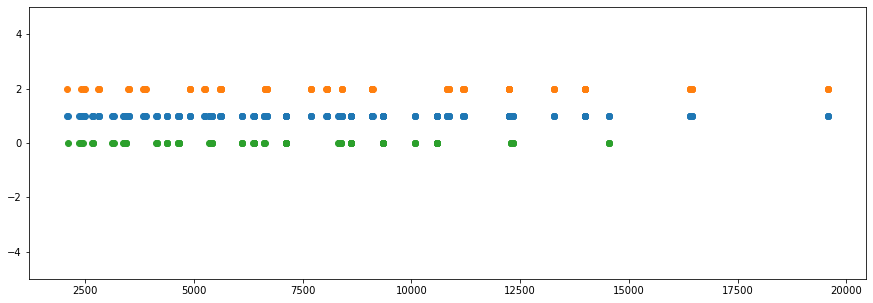

In [84]:
Ndata = 121

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(values_3x3[:], np.ones(len(values_3x3)), 'o')
ax.plot(values_Wannier_2[:]+H_Wannier_2.Egap, np.ones(len(values_Wannier_2))+1, 'o')
ax.plot(values_Wannier_1[:]+H_Wannier_1.Egap, np.ones(len(values_Wannier_1))-1, 'o')
ax.set_ylim([-5,5])
plt.show()

In [85]:
H_Wannier_2.Egap

2400.0

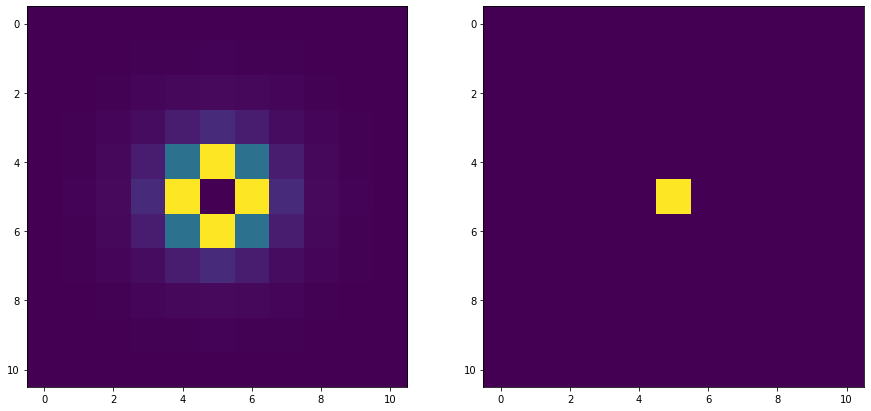

In [86]:
fig, ax = plt.subplots(ncols=2,figsize=(15,8))
ax[0].imshow(np.abs(vectors_3x3[0::2,0].reshape(11,11)))
ax[1].imshow(np.abs(vectors_3x3[1::2,0].reshape(11,11)))
plt.show()

In [87]:
print(np.sum(np.abs(vectors_3x3[0::2,0])))
print(np.sum(np.abs(vectors_3x3[1::2,0])))

1.088155909804494
0.9483797559163851


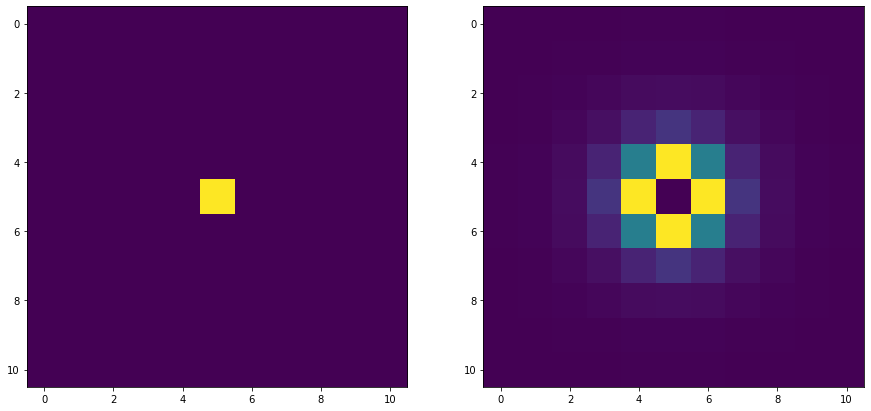

In [88]:
fig, ax = plt.subplots(ncols=2,figsize=(15,8))
ax[0].imshow(np.abs(vectors_3x3[0::2,1].reshape(11,11)))
ax[1].imshow(np.abs(vectors_3x3[1::2,1].reshape(11,11)))
plt.show()

In [89]:
print(np.sum(np.abs(vectors_3x3[0::2,1])))
print(np.sum(np.abs(vectors_3x3[1::2,1])))

0.8872206776005541
1.6915091697292708


In [90]:
abs_vector_1 = np.sum(np.abs(vectors_3x3[0::2,:])**2, axis=0)
abs_vector_2 = np.sum(np.abs(vectors_3x3[1::2,:])**2, axis=0)

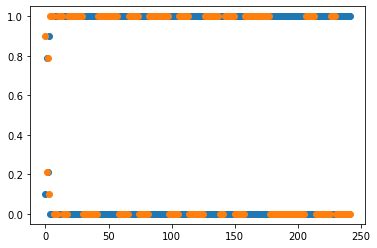

In [91]:
plt.plot(abs_vector_1,'o')
plt.plot(abs_vector_2,'o')

# Analysing the Builder functions

The BSE matrix for a decoupled Hamiltonian (diagonal) has to be, in sort of speaking, a combination of Wannier equations matrices, one for each conduction-valence combination. The BSE matrix of a 2x2 Hamiltonian (one conduction and one valence band) has to be equal to that obtained for the Wannier equation.

## BSE implementation details

In [92]:
[wannier_kinetic_1[i,i] for i in range(3)]

[12382.440792170684, 10153.60144957996, 8420.059738676066]

In [93]:
np.array([BSE_kinetic_1[i,i] for i in range(3)])- H_2x2_1.Egap

array([12382.44079217, 10153.60144958,  8420.05973868])

In [94]:
np.diag(BSE_kinetic_1)[:3] - H_2x2_1.Egap

array([12382.44079217, 10153.60144958,  8420.05973868])

(-0.1, 0.1)

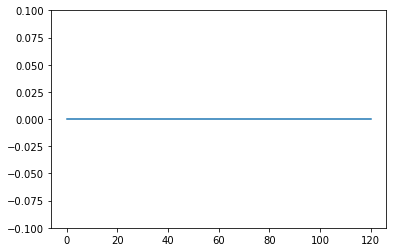

In [95]:
plt.plot(np.diag(wannier_kinetic_1) - (np.diag(BSE_kinetic_1) - H_2x2_1.Egap))
plt.ylim(-0.1,0.1)

### Diagonal terms

Let's start by analysing the function `bethe_salpeter_equation.diagonal_elements()`

In [96]:
cond_n, vale_n = H_3x3.condBands, H_3x3.valeBands # Just to set the size of the holder matrix
cond_inds = list(range(-1, -1*(cond_n+1), -1))    # NEW VERSION
vale_inds = list(range(vale_n))                 # NEW VERSION

In [97]:
cond_inds

[-1, -2]

In [98]:
vale_inds

[0]

In [99]:
print(Values3D_3x3.shape)
print(Vectors4D_3x3.shape)

(11, 11, 3)
(11, 11, 3, 3)


In [100]:
Values3D_3x3[0,0,:]

array([-4762.47715679, 10069.96356441, 15099.93876937])

In [101]:
Vectors4D_3x3[0,0,:,:]

array([[0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j]])

In [102]:
H_3x3.call(0,0)

array([[2450.+0.j,    0.+0.j,    0.+0.j],
       [   0.+0.j, 2400.+0.j,    0.+0.j],
       [   0.+0.j,    0.+0.j,    0.+0.j]])

In [103]:
def explicit_diag(kx,ky,E,m):
    return E + const.hbar2_over2m/m * (kx**2 + ky**2)

In [104]:
E_test_3 = explicit_diag(-5,-5 , 0, -0.4)
E_test_2 = explicit_diag(-5,-5 , 2.40e3, 0.15)
E_test_1 = explicit_diag(-5,-5 , 2.45e3, 0.25)


print('E_3 = {:.3f}'.format(E_test_3))
print('E_2 = {:.3f}'.format(E_test_2))
print('E_1 = {:.3f}'.format(E_test_1))

E_3 = -4762.477
E_2 = 15099.939
E_1 = 10069.964


In [105]:
# First we get some information about the shape of "Values"
kx_len, ky_len, num_vals = Values3D_3x3.shape

# Then we initiate the Matrix that will contain the values (Ec - Ev) in its diagonal
Wdim = kx_len * ky_len * cond_n * vale_n

# print("W_diagonal_len : ", Wdim)
W_diagonal = np.zeros(Wdim, dtype=float)

In [106]:
n = 0 # initiate the counter to popupate W_diagonal

# Now we run over all (kx, ky) pairs and split the values into "conduction" and "valence"
for i, j in it.product(range(ky_len), range(kx_len)):
    
    # REMEMBER THAT THE SECOND INDEX IS THE FASTEST
    # For each pair conduction valence we calculate (Ec - Ev)
    
    for v_ind, c_ind in it.product(vale_inds, cond_inds):
        # REMEMBER THAT THE SECOND INDEX IS THE FASTEST
        diag_val = Values3D_3x3[i,j,c_ind] - Values3D_3x3[i,j,v_ind]
        W_diagonal[n] = diag_val # save in right place
        n += 1 # update the counter

# Now we put this array into the main diagonal of a matrix
W_diag_matrix = np.diagflat(W_diagonal)

In [107]:
W_diagonal[:5]

array([19862.41592616, 14832.4407212 , 16719.18105945, 12603.60139139,
       14274.44282979])

In [108]:
[BSE_kinetic_3x3[i,i] for i in range(5)][::2]

[19862.41592616251, 16719.181059453254, 14274.442829790505]

In [109]:
[BSE_kinetic_2[i,i] for i in range(3)]

[19862.416198989027, 16719.181283171, 14274.443015312538]

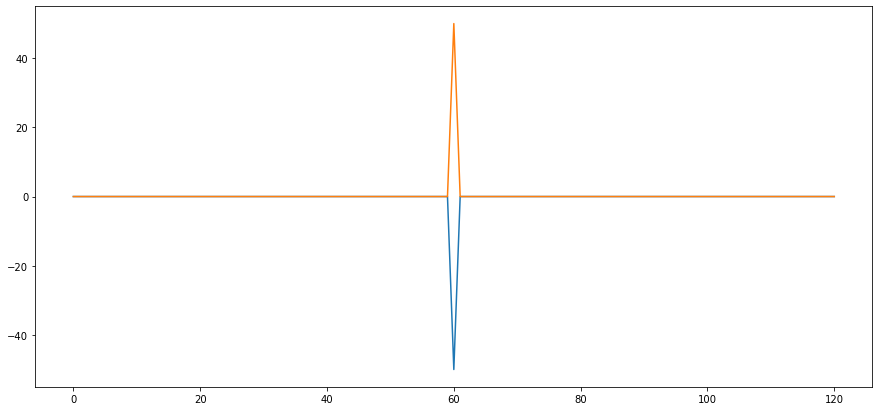

In [110]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(np.diag(BSE_kinetic_2) - np.diag(BSE_kinetic_3x3)[::2])
ax.plot(np.diag(BSE_kinetic_1) - np.diag(BSE_kinetic_3x3)[1::2])

### $\Delta$-term

In [111]:
BSE_potential_1.shape

(121, 121)

In [112]:
np.real(BSE_potential_1[0,:5]).round(2)

array([-287.26,  -41.67,  -11.46,   -5.27,   -3.02])

In [113]:
BSE_potential_3x3.shape

(242, 242)

In [114]:
np.real(BSE_potential_3x3[:2,:2])

array([[-287.25723041,   -0.        ],
       [  -0.        , -287.25723041]])

In [115]:
np.real(BSE_potential_3x3[:2,2:4])

array([[-41.66863158,  -0.        ],
       [ -0.        , -41.66863158]])

In [116]:
np.real(BSE_potential_1[:2,2:4])

array([[-11.45887368,  -5.26844767],
       [-41.66863158, -11.45887368]])

In [117]:
np.real(BSE_potential_3x3[0,0:10]).round(2)

array([-287.26,   -0.  ,  -41.67,   -0.  ,  -11.46,   -0.  ,   -5.27,
         -0.  ,   -3.02,   -0.  ])

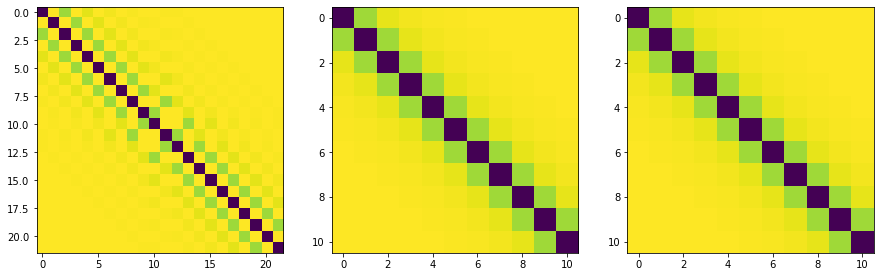

In [118]:
n = 6
fig,ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(BSE_potential_3x3[(n-1)*22:n*22,(n-1)*22:n*22].real)
ax[1].imshow(BSE_potential_1[(n-1)*11:n*11,(n-1)*11:n*11].real)
ax[2].imshow(BSE_potential_2[(n-1)*11:n*11,(n-1)*11:n*11].real)

#### Breaking the $\Delta$-term into blocks

In [119]:
BSE_pot_3x3_odd_cols_rows = BSE_potential_3x3[::2,::2]

In [120]:
BSE_pot_3x3_odd_cols_rows.shape

(121, 121)

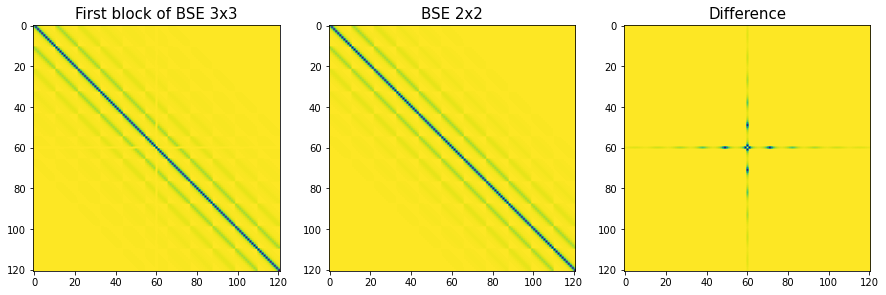

In [121]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(BSE_pot_3x3_odd_cols_rows.real)
ax[0].set_title('First block of BSE 3x3', fontsize=15)
ax[1].imshow(BSE_potential_1.real)
ax[1].set_title('BSE 2x2', fontsize=15)
ax[2].imshow((BSE_potential_1-BSE_pot_3x3_odd_cols_rows).real)
ax[2].set_title('Difference', fontsize=15)
plt.show()

In [122]:
max_diff = np.max(np.abs(BSE_potential_1-BSE_pot_3x3_odd_cols_rows))
print('The max difference between ' +
      'BSE 3x3 (first block) and the '+
      'correspondent BSE 2x2 is:\n {:.3e}'.format(max_diff))

The max difference between BSE 3x3 (first block) and the correspondent BSE 2x2 is:
 4.167e+01


In [123]:
BSE_pot_3x3_even_cols_rows = BSE_potential_3x3[1::2,1::2]

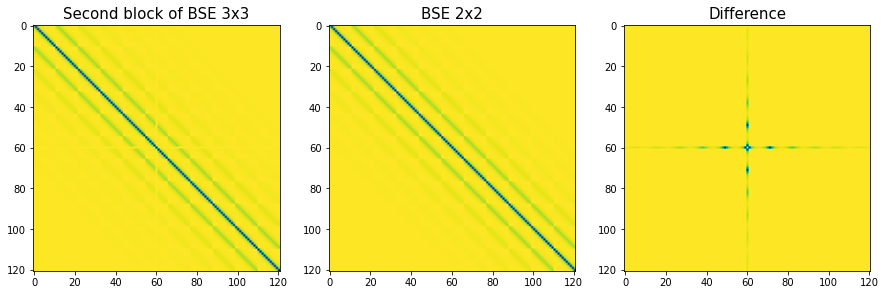

In [124]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(BSE_pot_3x3_even_cols_rows.real)
ax[0].set_title('Second block of BSE 3x3', fontsize=15)
ax[1].imshow(BSE_potential_2.real)
ax[1].set_title('BSE 2x2', fontsize=15)
ax[2].imshow((BSE_potential_2-BSE_pot_3x3_even_cols_rows).real)
ax[2].set_title('Difference', fontsize=15)
plt.show()

In [125]:
max_diff_2 = np.max(np.abs(BSE_potential_2-BSE_pot_3x3_even_cols_rows))
print('The max difference between ' +
      'BSE 3x3 (first block) and the '+
      'correspondent BSE 2x2 is:\n {:.3e}'.format(max_diff))

The max difference between BSE 3x3 (first block) and the correspondent BSE 2x2 is:
 4.167e+01


In [126]:
BSE_pot_3x3_coupling_12_cols_rows = BSE_potential_3x3[0::2,1::2]
BSE_pot_3x3_coupling_21_cols_rows = BSE_potential_3x3[1::2,0::2]

In [127]:
BSE_pot_3x3_coupling_12_cols_rows.shape

(121, 121)

In [128]:
BSE_pot_3x3_coupling_21_cols_rows.shape

(121, 121)

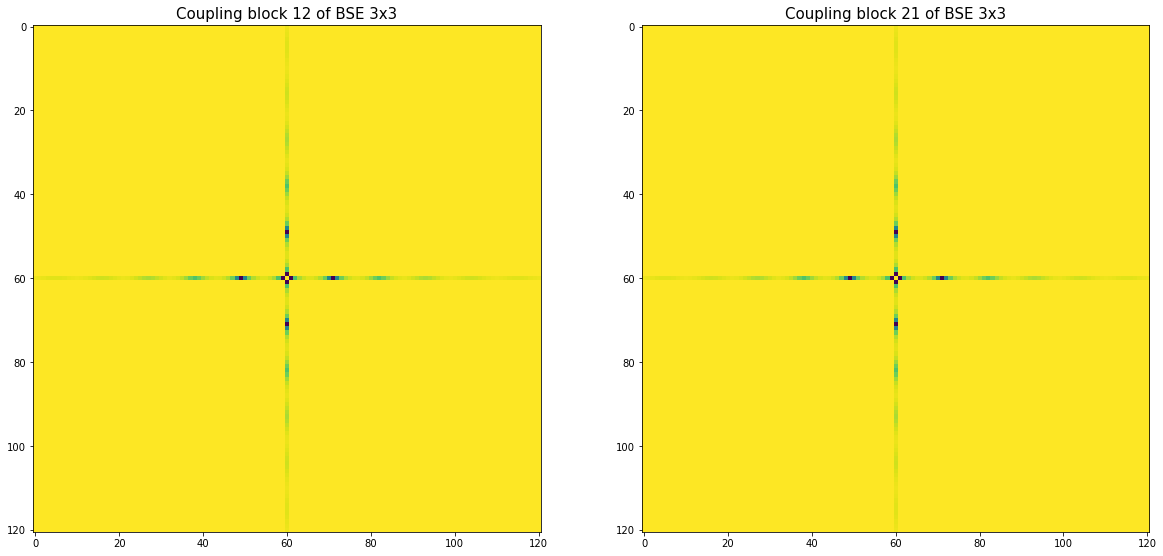

In [129]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(BSE_pot_3x3_coupling_12_cols_rows.real)
ax[0].set_title('Coupling block 12 of BSE 3x3', fontsize=15)
ax[1].imshow(np.real(BSE_pot_3x3_coupling_21_cols_rows))
ax[1].set_title('Coupling block 21 of BSE 3x3', fontsize=15)
plt.show()

In [130]:
np.max(np.abs(BSE_pot_3x3_coupling_12_cols_rows))

41.66863157782563

In [131]:
np.max(np.abs(BSE_pot_3x3_coupling_21_cols_rows))

41.66863157782563

#### Breaking the total BSE matrix into blocks

In [132]:
BSE_3x3_odd_cols_rows = BSE_matrix_total_3x3[::2,::2]
BSE_3x3_even_cols_rows = BSE_matrix_total_3x3[1::2,1::2]

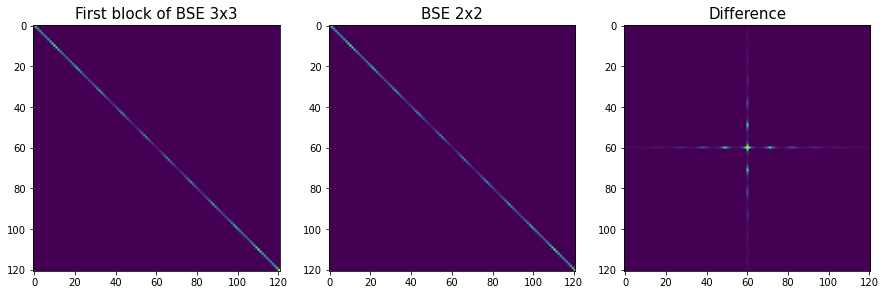

In [133]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(np.abs(BSE_3x3_odd_cols_rows))
ax[0].set_title('First block of BSE 3x3', fontsize=15)
ax[1].imshow(np.abs(BSE_matrix_total_2))
ax[1].set_title('BSE 2x2', fontsize=15)
ax[2].imshow(np.abs(BSE_matrix_total_2 - BSE_3x3_odd_cols_rows))
ax[2].set_title('Difference', fontsize=15)
plt.show()

In [134]:
np.abs(BSE_matrix_total_2[:3,:3] - BSE_3x3_odd_cols_rows[:3,:3])

array([[0.00027283, 0.        , 0.        ],
       [0.        , 0.00022372, 0.        ],
       [0.        , 0.        , 0.00018552]])

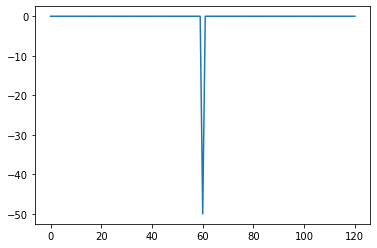

In [135]:
plt.plot(np.real(np.diag(BSE_matrix_total_2 - BSE_3x3_odd_cols_rows)))

In [136]:
np.sum((BSE_matrix_total_1 - BSE_3x3_odd_cols_rows) != 0)

360

In [137]:
BSE_3x3_even_cols_rows = BSE_matrix_total_3x3[1::2,1::2]

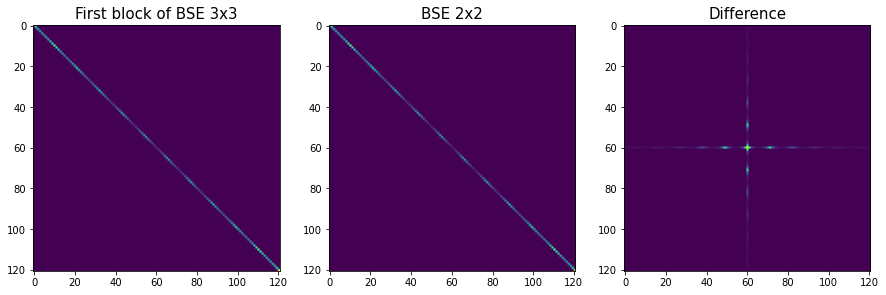

In [138]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(np.abs(BSE_3x3_even_cols_rows))
ax[0].set_title('First block of BSE 3x3', fontsize=15)
ax[1].imshow(np.abs(BSE_matrix_total_2))
ax[1].set_title('BSE 2x2', fontsize=15)
ax[2].imshow(np.abs(BSE_matrix_total_2 - BSE_3x3_odd_cols_rows))
ax[2].set_title('Difference', fontsize=15)
plt.show()

In [139]:
np.max(np.abs(BSE_matrix_total_2 - BSE_3x3_even_cols_rows))

5029.975477784781

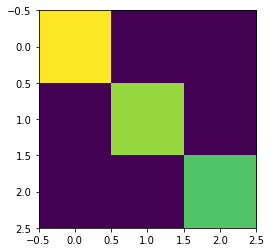

In [140]:
plt.imshow(np.abs(BSE_3x3_even_cols_rows[:3,:3]))

In [141]:
np.abs(BSE_3x3_even_cols_rows[:3,:3])

array([[1.45451835e+04, 4.16686316e+01, 1.14588737e+01],
       [4.16686316e+01, 1.23163442e+04, 4.16686316e+01],
       [1.14588737e+01, 4.16686316e+01, 1.05828025e+04]])

In [142]:
BSE_3x3_even_cols_rows[0,0] - BSE_pot_3x3_even_cols_rows[0,0]

(14832.440721204246+0j)

In [143]:
BSE_kinetic_1[0,0]

14832.440792170686

In [144]:
BSE_kinetic_3x3_odd_cols_rows = BSE_kinetic_3x3[::2,::2]
BSE_kinetic_3x3_even_cols_rows = BSE_kinetic_3x3[1::2,1::2]

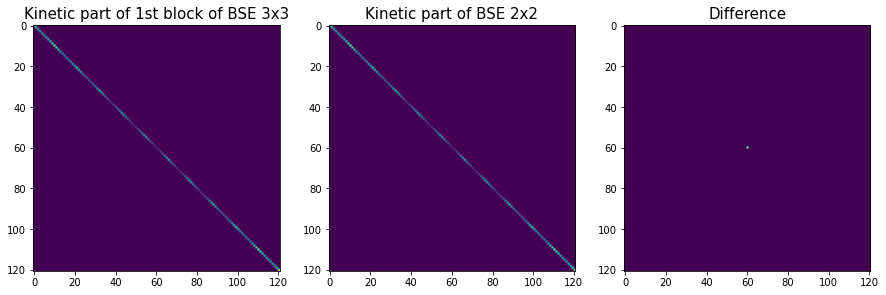

In [145]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(np.abs(BSE_kinetic_3x3_odd_cols_rows))
ax[0].set_title('Kinetic part of 1st block of BSE 3x3', fontsize=15)
ax[1].imshow(np.abs(BSE_kinetic_2))
ax[1].set_title('Kinetic part of BSE 2x2', fontsize=15)
ax[2].imshow(np.abs(BSE_kinetic_2 - BSE_kinetic_3x3_odd_cols_rows))
ax[2].set_title('Difference', fontsize=15)
plt.show()

In [146]:
BSE_kinetic_2[0,0]

19862.416198989027

In [147]:
BSE_kinetic_3x3_odd_cols_rows[0,0]

19862.41592616251

## Ordering of the states

In [148]:
kx_array_red = np.linspace(-5,5,11)
bands3x3_reduced = [LA.eigh(H_3x3.call(kx,0))[0] for kx in kx_array_red]

In [149]:
np.array(bands3x3_reduced).shape

(11, 3)

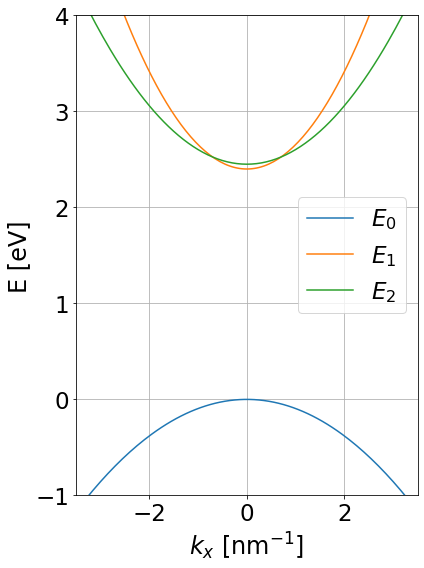

In [228]:
fig, ax = plt.subplots(figsize=(6,8))
# lines = ax.plot(kx_array, np.array(bands3x3)/1000)
ax.plot(kx_array, np.array(bands3x3_organized)/1000)
ax.legend([r'$E_{0}$',r'$E_{1}$',r'$E_{2}$'],fontsize=23,loc=0)

# ax.plot(kx_array_red, np.array(bands3x3_reduced)[:,0]/1000, 'o', color='C0')
# ax.plot(kx_array_red, np.array(bands3x3_reduced)[:,1]/1000, 'o', color='C1')
# ax.plot(kx_array_red, np.array(bands3x3_reduced)[:,2]/1000, 'o', color='C2')

ax.set_ylim((-1,4))
ax.set_xlim((-3.5,3.5))
ax.tick_params(labelsize=23)
ax.set_xlabel('$k_x$ [nm$^{-1}$]', fontsize=24)
ax.set_ylabel('E [eV]', fontsize=24)
ax.grid()

plt.tight_layout()
# plt.savefig('bands_3x3_separated_bands.png', dpi=300)
plt.show()

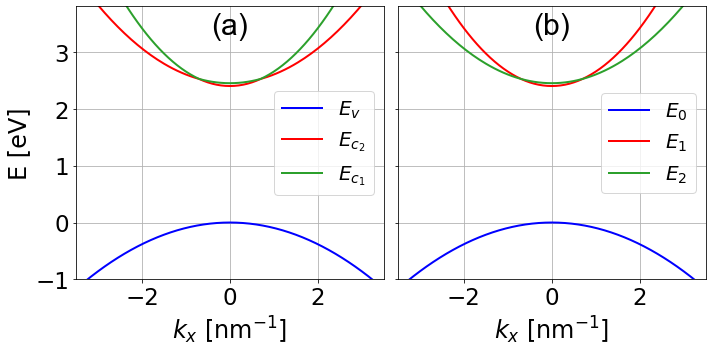

In [260]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))


# lines = ax.plot(kx_array, np.array(bands3x3)/1000)

ax[0].plot(kx_array, np.array(bands3x3)[:,0]/1000, c='b', lw=2)
ax[0].plot(kx_array, np.array(bands3x3)[:,1]/1000, c='r', lw=2)
ax[0].plot(kx_array, np.array(bands3x3)[:,2]/1000, c='C2', lw=2)
ax[0].legend([r'$E_{v}$',r'$E_{c_2}$',r'$E_{c_1}$'],fontsize=20,loc=0)

ax[1].plot(kx_array, np.array(bands3x3_organized)[:,0]/1000, c='b', lw=2)
ax[1].plot(kx_array, np.array(bands3x3_organized)[:,1]/1000, c='r', lw=2)
ax[1].plot(kx_array, np.array(bands3x3_organized)[:,2]/1000, c='C2', lw=2)
ax[1].legend([r'$E_{0}$',r'$E_{1}$',r'$E_{2}$'],fontsize=20,loc=0)

# ax.plot(kx_array_red, np.array(bands3x3_reduced)[:,0]/1000, 'o', color='C0')
# ax.plot(kx_array_red, np.array(bands3x3_reduced)[:,1]/1000, 'o', color='C1')
# ax.plot(kx_array_red, np.array(bands3x3_reduced)[:,2]/1000, 'o', color='C2')

for i in range(2):
    ax[i].set_ylim((-1,4))
    ax[i].set_xlim((-3.5,3.5))
    ax[i].tick_params(labelsize=23)
    ax[i].set_xlabel('$k_x$ [nm$^{-1}$]', fontsize=24)
    ax[i].set_xlim((-3.5,3.5))
    ax[i].set_ylim(-1,3.8)
    ax[i].grid()
    
ax[0].text(0.5, 0.98,'(a)',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = ax[0].transAxes)

ax[1].text(0.5, 0.98,'(b)',
           fontsize=30,
           fontname='Arial',
           horizontalalignment='center',
           verticalalignment='top',
           transform = ax[1].transAxes)


ax[0].set_ylabel('E [eV]', fontsize=24)
ax[1].get_yaxis().set_ticklabels([])

plt.tight_layout()
plt.savefig('bands_3x3_joint_and_separated_bands.png', dpi=300)
plt.show()

In [151]:
np.where(Kx.flatten()==0)

(array([  5,  16,  27,  38,  49,  60,  71,  82,  93, 104, 115]),)

In [152]:
np.where(Ky.flatten()==0)

(array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),)

In [153]:
states3x3_red = [LA.eigh(H_3x3.call(kx,0))[1] for kx in kx_array_red]
states_composition_3x3_red = [np.real(matrix_states @ np.array([-1,1,2])) for matrix_states in states3x3_red]

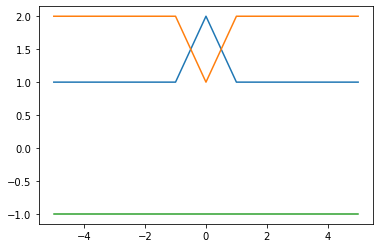

In [154]:
plt.plot(kx_array_red, states_composition_3x3_red)
plt.show()

In [155]:
np.array(states3x3_red).shape

(11, 3, 3)

In [156]:
states3x3_red[0]

array([[0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j]])

In [157]:
values_2x2_1[:3]

array([2110.55308586, 2351.57710406, 2409.43418318])

In [158]:
values_2x2_2[:3]

array([2079.61815309, 2399.27960505, 2464.9040601 ])

## Mapping $\{|v\rangle,|c1\rangle,|c2\rangle\} \rightarrow \{|1\rangle,|2\rangle,|3\rangle\}$

Internally, our code considers the states based on energy following correspondence rule, given by

* $E_{c_1}$ is the highest energy value
* $E_{c_j}$ for $j > 1$ goes decreasingly until $j=N_c$; 
    * where $N_c$ is the total number of conduction bands
* $E_{v_1}$ is the lowest energy value
* $E_{v_j}$ for $j > 1$ goes increasingly until $j=N_v$; 
    * where $N_c$ is the total number of valence bands

However, it is of great importance to know the composition of the excitons in terms of the original basis, i.e., in which the Hamiltonian is written.

In [159]:
Vectors4D_3x3.shape

(11, 11, 3, 3)

In [160]:
nkx, nky, nstates = Values3D_3x3.shape # nkx -> kx-points; nky -> ky -> points; nstates -> # of eigenvalues
Vect_flat = Vectors4D_3x3.reshape(nkx*nky, nstates, nstates)

In [161]:
# Hamiltonian basis
# bra_0 = np.array([1,0,0],dtype=complex) # conduction
# bra_1 = np.array([0,1,0],dtype=complex) # conduction
# bra_2 = np.array([0,0,1],dtype=complex) # valence

basis_cond, basis_vale = H_3x3.basis()
bra_0 = basis_vale[0]
bra_1 = basis_cond[1]
bra_2 = basis_cond[0]

print(H_3x3.basis())

print("Basis vectors:")
print("|0> := ", bra_0.real)
print("|1> := ", bra_1.real)
print("|2> := ", bra_2.real)
print()
print("The energies for kx = ky = 0 for each band are:")
print("\t E0 = {:.2e} meV ".format(H_3x3.E0))
print("\t E1 = {:.2e} meV ".format(H_3x3.E1))
print("\t E2 = {:.2e} meV ".format(H_3x3.E2))
print('')
print("The effective masses for each band (without coupling) are:")
print("\t m0 = {:.2f} meV ".format(H_3x3.m0))
print("\t m1 = {:.2f} meV ".format(H_3x3.m1))
print("\t m2 = {:.2f} meV ".format(H_3x3.m2))

print(H_3x3.call(0,0))

([array([1, 0, 0]), array([0, 1, 0])], [array([0, 0, 1])])
Basis vectors:
|0> :=  [0 0 1]
|1> :=  [0 1 0]
|2> :=  [1 0 0]

The energies for kx = ky = 0 for each band are:
	 E0 = 0.00e+00 meV 
	 E1 = 2.40e+03 meV 
	 E2 = 2.45e+03 meV 

The effective masses for each band (without coupling) are:
	 m0 = -0.40 meV 
	 m1 = 0.15 meV 
	 m2 = 0.25 meV 
[[2450.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j 2400.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j]]


In [162]:
def break_A(A_bse, cond_n, vale_n):
    decomp_list = []
    N_combinations = cond_n * vale_n
    for n in range(N_combinations):
        decomp_list.append(A_bse[n : : N_combinations])
    return decomp_list

def break_V(V_flat, cond_n, vale_n):
    cond_inds = list(range(-1,-1*(cond_n+1),-1)) # [-1,-2, ... , -cond_n]
    vale_inds = list(range(vale_n))              # [0,1,2, ... , (vale_n - 1)]
    c_states = [V_flat[:,:,c] for c in cond_inds]
    v_states = [V_flat[:,:,v] for v in vale_inds]
    return c_states, v_states

In [163]:
def single_product(A_cv, c_vectors, v_vectors, bra_cond, bra_vale):
    braket_cond = np.array([ *map(lambda c: bra_cond @ c, c_vectors) ])
    braket_vale = np.array([ *map(lambda v: bra_vale @ v, v_vectors) ])
    return A_cv * braket_cond * braket_vale

In [164]:
def map_bse_wavefunction(A_bse, Vectors, cond_n, vale_n, state_c, state_v):
    ## VERIFY THE SHAPE OF THE INPUTS
    nkx, nky, nstates,_ = Vectors.shape # nkx -> kx-points; nky -> ky -> points; nstates -> # of eigenvalues
    Vectors_flat = Vectors.reshape(nkx*nky, nstates, nstates)
    N_combinations = cond_n * vale_n

    ## BREAK THE BSE EIGENVECTOR IN TERMS OF Conduction-Valence PAIRS
    A_cv_list = break_A(A_bse, cond_n, vale_n)
    c_states, v_states = break_V(Vectors_flat, cond_n, vale_n)

    ## CALCULATE THE PROJECTION OF THE STATE OVER |state_c, state_v> 
    A_proj = np.sum([single_product(A, c_vectors, v_vectors, state_c, state_v)
               for A, (v_vectors, c_vectors) in zip(A_cv_list, it.product(v_states, c_states))],
               axis=0)
    return A_proj

In [165]:
def map_wavefunction_over_all_pairs(A_bse, Vectors, cond_n, vale_n, states_c, states_v):
    A_list = []
    for v_state, c_state in it.product(states_v, states_c):
        A_proj = map_bse_wavefunction(A0, Vectors4D_3x3, cond_n, vale_n, c_state, v_state)
        A_list.append(A_proj)
    return A_list

In [166]:


A0    = vectors_3x3[:, 0]
cond_n, vale_n = H_3x3.condBands, H_3x3.valeBands
A_proj_list = map_wavefunction_over_all_pairs(A0, Vectors4D_3x3, cond_n, vale_n, basis_cond, basis_vale)
A0_1, A0_2 = A_proj_list
A0_c1, A0_c2 = break_A(A0, 2, 1)

np.array(A_proj_list).shape


(2, 121)

In [167]:
component_1 = np.sum(np.abs(A0_1)**2)
component_2 = np.sum(np.abs(A0_2)**2)
print("The first BSE's eigenstate is composed by\n\t {0:.2f} |1,0> + {1:.2f} |2,0>".format(component_1, component_2))

The first BSE's eigenstate is composed by
	 0.00 |1,0> + 1.00 |2,0>


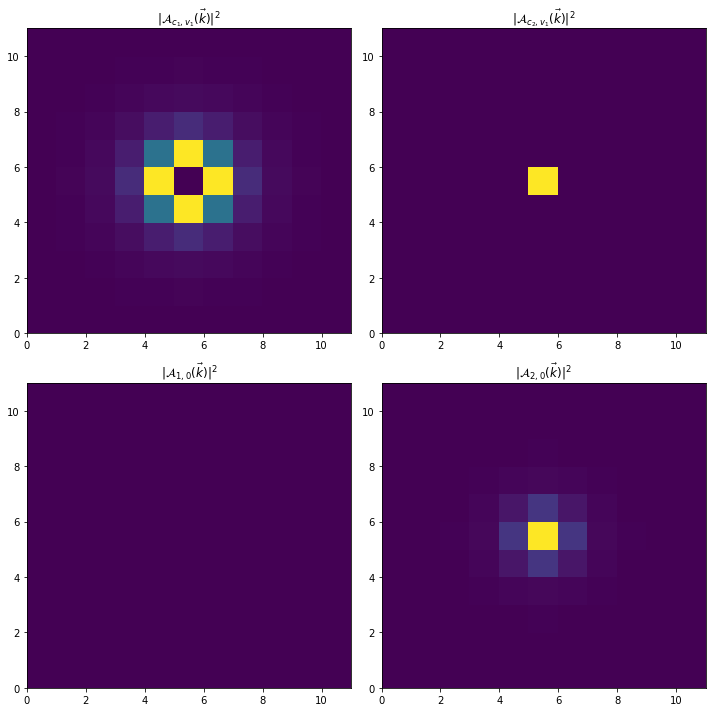

In [168]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
ax[0,0].set_title(r"$|\mathcal{A}_{c_1,v_1}(\vec{k})|^2$")
ax[0,1].set_title(r"$|\mathcal{A}_{c_2,v_1}(\vec{k})|^2$")
ax[1,0].set_title(r"$|\mathcal{A}_{1,0}(\vec{k})|^2$")
ax[1,1].set_title(r"$|\mathcal{A}_{2,0}(\vec{k})|^2$")

ax[0,0].pcolormesh(np.abs(A0_c1.reshape(11,11)))
ax[0,1].pcolormesh(np.abs(A0_c2.reshape(11,11)))
ax[1,0].pcolormesh(np.abs(A0_1.reshape(11,11)), vmax=max(np.max(np.abs(A0_1)),np.max(np.abs(A0_2))))
ax[1,1].pcolormesh(np.abs(A0_2.reshape(11,11)), vmax=max(np.max(np.abs(A0_1)),np.max(np.abs(A0_2))))

plt.tight_layout()
plt.show()

In [169]:
Vect_flat.shape

(121, 3, 3)

In [170]:
np.abs(Vectors4D_3x3[:,:,0,1])

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [171]:
np.abs(Vectors4D_3x3[:,:,1,2])

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [172]:
Values3D_3x3[0,0,0]

-4762.477156791517

In [173]:
print('Eigenvector with the smallest eigenvalue at k=(-5,-5) : \n |V):=', np.abs(Vectors4D_3x3[0,0,:,0]))
print('Eigenvector with eigenvalue in the half-way at k=(-5,-5) : \n |C2):=',np.abs(Vectors4D_3x3[0,0,:,1]))
print('Eigenvector with the highest eigenvalue at k=(-5,-5) : \n |C1):=',np.abs(Vectors4D_3x3[0,0,:,2]))

Eigenvector with the smallest eigenvalue at k=(-5,-5) : 
 |V):= [0. 0. 1.]
Eigenvector with eigenvalue in the half-way at k=(-5,-5) : 
 |C2):= [1. 0. 0.]
Eigenvector with the highest eigenvalue at k=(-5,-5) : 
 |C1):= [0. 1. 0.]


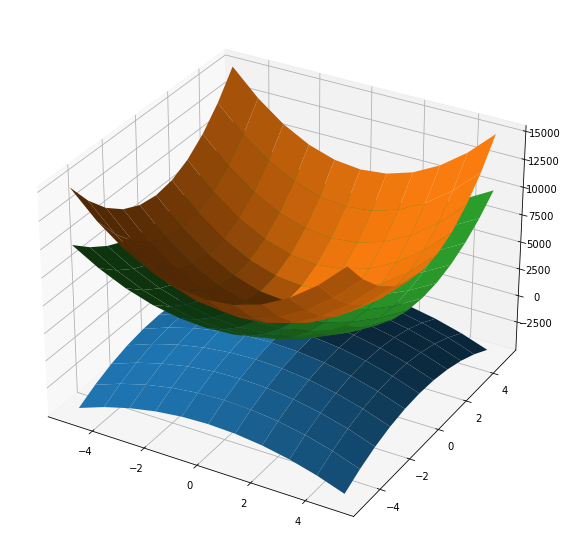

In [174]:
## PLOT 3D BANDS 
k_plot = np.linspace(-5,5,11)
Kx, Ky = np.meshgrid(k_plot, k_plot)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(Kx, Ky, Values3D_3x3[:,:,0])
ax.plot_surface(Kx, Ky, Values3D_3x3[:,:,-1])
ax.plot_surface(Kx, Ky, Values3D_3x3[:,:,-2])
plt.show()

In [175]:
def analyse_all_bse_states(A_Ns, Vectors, cond_n, vale_n, cond_vects, vale_vects):
    All_bse_decomposed_list = []
    for A_N in A_Ns:
        A_N_decomposed_list = map_wavefunction_over_all_pairs(A_N, Vectors, cond_n, vale_n, cond_vects, vale_vects)
        All_bse_decomposed_list.append(A_N_decomposed_list)
    All_bse_decomposed_list = np.array(All_bse_decomposed_list)
    return All_bse_decomposed_list

In [176]:
All_decomposed = analyse_all_bse_states(vectors_3x3, Vectors4D_3x3, cond_n, vale_n, basis_cond, basis_vale)

In [177]:
All_decomposed.shape

(242, 2, 121)

In [178]:
values_3x3.shape

(242,)